# Resample Data to Specific Spatio-Temporal Resolutions 

## xr.datarray.coarsen to resample spatially 
## xr.datarray.resample to resample temporally

In [3]:
# import libraries
from pathlib import Path
import xarray as xr 
import rioxarray

In [4]:
#insert the path you have saved the cube 

ds=xr.open_zarr(Path.home() / 'SeasFireCube8daily.zarr')

In [5]:
ds

<xarray.Dataset>
Dimensions:             (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * latitude            (latitude) float64 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude           (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12...
Data variables: (12/38)
    BAs_GWIS            (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    BurntArea           (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCCI_BA             (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCD_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FRP_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                  ...
    t2mmax              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2mmin              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd_cf              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    wp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>

## Spatial aggregation of a variable from 0.25 degrees to 1 degree

In [9]:
resampled_t2max=ds['t2mmax'].coarsen(longitude=4,latitude=4).mean()

/tmp/ipykernel_1791296/1570312381.py:1: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  resampled_t2max=ds['t2mmax'].coarsen(longitude=4,latitude=4).mean()


In [10]:
resampled_t2max

<xarray.DataArray 't2mmax' (time: 966, latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(966, 180, 360), dtype=float32, chunksize=(966, 45, 90), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12-27T12:00:00

In [11]:
#plot a time frame
#resampled_t2max[1,:,:].plot()

## Resample the coarsen variable temporally to get 3 month averages 

In [12]:
monthly_t2max=resampled_t2max.resample(time='3MS').mean()


In [13]:
monthly_t2max

,Array,Chunk
Bytes,20.76 MiB,15.82 kiB
Shape,"(84, 180, 360)","(1, 45, 90)"
Count,5441 Tasks,1344 Chunks
Type,float32,numpy.ndarray


## Select a specific location

In [14]:
#select a specific location
#lat, lon doen't have to be the exact same as the lat lon in the dataset 
# it would take the nearest
ds_sel = monthly_t2max.sel(latitude=19.4721, longitude=-155.5922, method='nearest')

## Select a region 

## Method 1: rioxarray bounding box 

In [15]:
#select a bounding box 
#first give a crs to the dataset 
#here as well it would take the nearest lat lon 
l=monthly_t2max.rio.write_crs(4326, inplace=True)


min_lon = -24.995
min_lat = 28.05
max_lon = 45.50
max_lat = 71.5545

subset = l.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)



In [16]:
subset 

<xarray.DataArray 't2mmax' (time: 84, latitude: 44, longitude: 71)>
dask.array<getitem, shape=(84, 44, 71), dtype=float32, chunksize=(1, 27, 46), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2001-01-01 2001-04-01 ... 2021-10-01
  * latitude     (latitude) float64 71.5 70.5 69.5 68.5 ... 31.5 30.5 29.5 28.5
  * longitude    (longitude) float64 -24.5 -23.5 -22.5 -21.5 ... 43.5 44.5 45.5
    spatial_ref  int64 0

## Method 2: xarray 

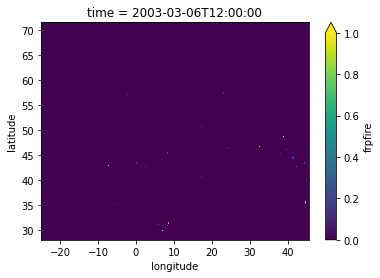

In [19]:
#vmax is for colorbar maximum value
time=100
ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon)).isel(time=time).frpfire.plot(vmax=1)

In [21]:
ds_sel_box=ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon)).isel(time=time).frpfire

In [22]:
ds_sel_box

<xarray.DataArray 'frpfire' (latitude: 174, longitude: 282)>
dask.array<getitem, shape=(174, 282), dtype=float64, chunksize=(106, 182), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 71.38 71.12 70.88 70.62 ... 28.62 28.38 28.12
  * longitude  (longitude) float64 -24.88 -24.62 -24.38 ... 44.88 45.12 45.38
    time       datetime64[ns] 2003-03-06T12:00:00